# 📊 Customer Feature Dashboard — Interview‑Ready Notebook

This notebook assumes you already have a **customer-level feature table** (one row per customer) with columns like:

- `CustomerID`, `Recency`, `Frequency`, `Monetary`, `Tenure`, engineered metrics
- One‑hot country columns like `Country_France`, `Country_Germany`, …
- Target label: `is_churned` (0 = not churned, 1 = churned)

✅ Goal: **Turn features into business insights** (EDA-style dashboard) in a way you can **explain in interviews**.

---
**What you will practice (interview signals):**
- Data validation & defensive coding
- Understanding feature-table vs transaction-table
- KPI framing (churn rate, customer segments)
- Plotting and interpreting results


## 0️⃣ Imports + configuration (Interview focus: reproducibility)

**Interview prompt:** *“How do you make your notebook reproducible and easy to run?”*

✅ Best practice:
- Put imports at top
- Use a single `DATA_PATH`
- Keep constants (target name) in one place


In [3]:
from __future__ import annotations
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# Configuration
# -------------------------
# Update this to your actual CSV path
DATA_PATH = Path('C:\\Users\\abhin\\ai-systems-foundations\\DeepLearningProject\\data\\processed\\customer_features_v2.csv')
TARGET_COL = 'is_churned'

# Optional: save plots to disk (helpful for portfolio/README screenshots)
SAVE_PLOTS = True
OUTPUT_DIR = Path('outputs')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Plot display defaults (simple and clean)
plt.rcParams['figure.dpi'] = 120


### Interview mini‑Q (Step 0)

1. **Why define constants like `TARGET_COL` once?**  
2. **When should you save plots to disk vs only display them?**  
3. **What are common reproducibility issues in notebooks?** (paths, random seeds, hidden state)


## 1️⃣ Load the feature table safely (Interview focus: schema validation)

Important: this file is a **feature table**, so it will NOT contain:
- `InvoiceDate`, `Quantity`, `UnitPrice`

If you see those columns, that’s a transaction table (different stage of pipeline).


In [5]:
def load_feature_table(path: Path, target: str = 'is_churned') -> pd.DataFrame:
    """
    Load a customer-level feature table.

    Interview-ready notes:
    - Validate file existence
    - Normalize column names
    - Validate target column presence
    - Coerce target to 0/1 integers
    """
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f'File not found: {path.resolve()}')

    df = pd.read_csv(path)

    # Normalize column headers (prevents whitespace-caused bugs)
    df.columns = df.columns.astype(str).str.strip()

    # Validate target existence
    if target not in df.columns:
        raise ValueError(
            f"Target '{target}' not found. Available columns: {df.columns.tolist()}"
        )

    # Enforce a clean binary target (0/1)
    df[target] = pd.to_numeric(df[target], errors='coerce')
    df[target] = df[target].fillna(0).astype(int)

    # Quick sanity check: we expect at least 2 classes for classification
    if df[target].nunique() < 2:
        raise ValueError(
            f"Target '{target}' has <2 classes: {df[target].unique().tolist()}"
        )

    return df

df = load_feature_table(DATA_PATH, target=TARGET_COL)
print('✅ Loaded:', DATA_PATH)
print('Shape:', df.shape)
print('Target distribution:\n', df[TARGET_COL].value_counts())
df.head()


✅ Loaded: C:\Users\abhin\ai-systems-foundations\DeepLearningProject\data\processed\customer_features_v2.csv
Shape: (3588, 23)
Target distribution:
 is_churned
0    1936
1    1652
Name: count, dtype: int64


,CustomerID,Frequency,Monetary,avg_basket_value,avg_items_per_invoice,Recency,Tenure,gap_mean,gap_median,gap_std,...,is_churned,Country_Belgium,Country_France,Country_Germany,Country_Netherlands,Country_Other,Country_Portugal,Country_Spain,Country_Switzerland,Country_United Kingdom
0,12346,1,77556.46,77556.46,74285.0,235,400,0.0,0.0,0.0,...,1,False,False,False,False,False,False,False,False,True
1,12347,1,4114.18,4114.18,2418.0,39,274,0.0,0.0,0.0,...,0,False,False,False,False,True,False,False,False,False
2,12348,1,1709.40,1709.40,2497.0,158,189,0.0,0.0,0.0,...,0,False,False,False,False,True,False,False,False,False
3,12349,1,2671.14,2671.14,993.0,317,181,0.0,0.0,0.0,...,0,False,False,False,False,True,False,False,False,False
4,12352,1,1905.61,1905.61,442.0,172,130,0.0,0.0,0.0,...,0,False,False,False,False,True,False,False,False,False


### Interview mini‑Q (Step 1)

1. **Why do we strip column names?**  
2. **Why check `nunique()` on the target?**  
3. **What’s the difference between `errors='coerce'` vs raising errors?**


## 2️⃣ Reconstruct a readable `Country` label from one‑hot columns (Interview focus: feature understanding)

Many pipelines one‑hot encode `Country` → columns like `Country_France`, `Country_Germany`, etc.

For dashboard insights, it’s easier to interpret a single `Country` label.


In [6]:
def add_country_label_from_onehot(df: pd.DataFrame, prefix: str = 'Country_') -> pd.DataFrame:
    """
    Create a readable Country label from one-hot encoded country columns.

    Interview-ready notes:
    - Find all one-hot columns by prefix
    - If none exist, set Country='Unknown'
    - Handle rows where all one-hot values are 0
    """
    country_cols = [c for c in df.columns if c.startswith(prefix)]
    if not country_cols:
        df['Country'] = 'Unknown'
        return df

    onehot = df[country_cols].copy()
    row_sum = onehot.sum(axis=1)

    # idxmax gives the column with highest value per row (works for one-hot)
    df['Country'] = onehot.idxmax(axis=1).str.replace(prefix, '', regex=False)

    # If a row has all zeros across one-hot columns, idxmax is not meaningful
    df.loc[row_sum == 0, 'Country'] = 'Unknown'

    return df

df = add_country_label_from_onehot(df, prefix='Country_')
df[['CustomerID','Country', TARGET_COL]].head() if 'CustomerID' in df.columns else df[['Country', TARGET_COL]].head()


,CustomerID,Country,is_churned
0,12346,United Kingdom,1
1,12347,Other,0
2,12348,Other,0
3,12349,Other,0
4,12352,Other,0


### Interview mini‑Q (Step 2)

1. **Why do we reconstruct a label after one‑hot encoding?**  
2. **What could go wrong with `idxmax` on all‑zero rows?**  
3. **What if multiple countries are 1 (bad data)? How would you handle it?**


## 3️⃣ KPI summary (Interview focus: business framing)

A dashboard is not only plots — start with **numbers** that executives understand.

Common churn dashboard KPIs:
- Customer count
- Churn rate
- Average RFM values (Recency/Frequency/Monetary)
- Average tenure


In [7]:
def kpi_summary(df: pd.DataFrame, target: str = 'is_churned') -> pd.DataFrame:
    """Create a compact KPI table for quick reporting."""
    def safe_mean(col: str) -> float:
        return float(df[col].mean()) if col in df.columns else float('nan')

    kpis = {
        'rows': int(len(df)),
        'unique_customers': int(df['CustomerID'].nunique()) if 'CustomerID' in df.columns else int(len(df)),
        'churn_rate': float(df[target].mean()),
        'avg_recency': safe_mean('Recency'),
        'avg_frequency': safe_mean('Frequency'),
        'avg_monetary': safe_mean('Monetary'),
        'avg_tenure': safe_mean('Tenure'),
    }
    return pd.DataFrame([kpis])

kpis = kpi_summary(df, target=TARGET_COL)
kpis


,rows,unique_customers,churn_rate,avg_recency,avg_frequency,avg_monetary,avg_tenure
0,3588,3588,0.460424,150.725195,1.0,3782.631991,329.879599


### Interview mini‑Q (Step 3)

1. **Why is churn rate a better KPI than churn count alone?**  
2. **How would you define churn if the business changes definition?** (e.g., 90 days inactivity → 60 days)  
3. **Which KPI would you monitor daily vs weekly vs monthly?**


## 4️⃣ Plot 1 — Churn distribution (Interview focus: imbalance)

Before any modeling or segmentation, always check class balance.

If churners are rare:
- accuracy becomes misleading
- ROC‑AUC / PR‑AUC become more useful
- threshold tuning becomes important


In [8]:
def save_or_show(fig, filename: str | None = None):
    if SAVE_PLOTS and filename:
        out = OUTPUT_DIR / filename
        fig.savefig(out, bbox_inches='tight', dpi=160)
        plt.close(fig)
        print('💾 Saved:', out)
    else:
        plt.show()

fig = plt.figure(figsize=(5.2, 4))
counts = df[TARGET_COL].value_counts().sort_index()
plt.bar(['Not Churned (0)', 'Churned (1)'], counts.values)
plt.title('Churn Distribution')
plt.ylabel('Customers')
save_or_show(fig, '01_churn_distribution.png')


💾 Saved: outputs\01_churn_distribution.png


### Interview mini‑Q (Plot 1)

1. **If churn class is only 5%, what metric do you prioritize? Why?**  
2. **How would you handle imbalance?** (class weights, SMOTE, threshold tuning)  
3. **What’s the risk of optimizing only accuracy?**


## 5️⃣ Plot 2 — Monetary vs churn (Interview focus: behavior differences)

If churners spend less (or more), this plot helps explain business patterns.


💾 Saved: outputs\02_monetary_by_churn.png


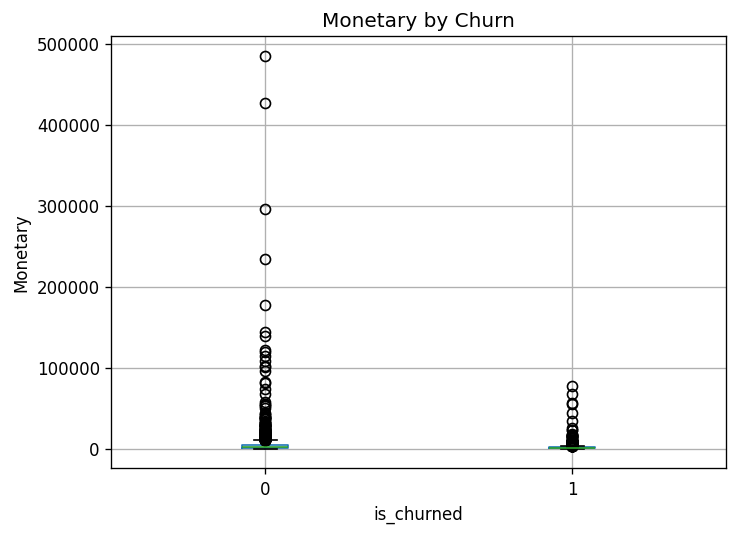

In [9]:
if 'Monetary' in df.columns:
    fig = plt.figure(figsize=(6.2, 4))
    df.boxplot(column='Monetary', by=TARGET_COL)
    plt.title('Monetary by Churn')
    plt.suptitle('')
    plt.xlabel(TARGET_COL)
    plt.ylabel('Monetary')
    save_or_show(fig, '02_monetary_by_churn.png')
else:
    print('Monetary column not found — skipping plot.')


### Interview mini‑Q (Plot 2)

1. **What does a wide box (IQR) suggest?**  
2. **If churners have higher Monetary, what could be the explanation?** (one-time bulk purchases, seasonal buyers)  
3. **Would you log-transform Monetary? When and why?**


## 6️⃣ Plot 3 — Recency vs churn (Interview focus: churn logic)

Recency is often the strongest churn signal: higher recency = longer since last purchase.


💾 Saved: outputs\03_recency_by_churn.png


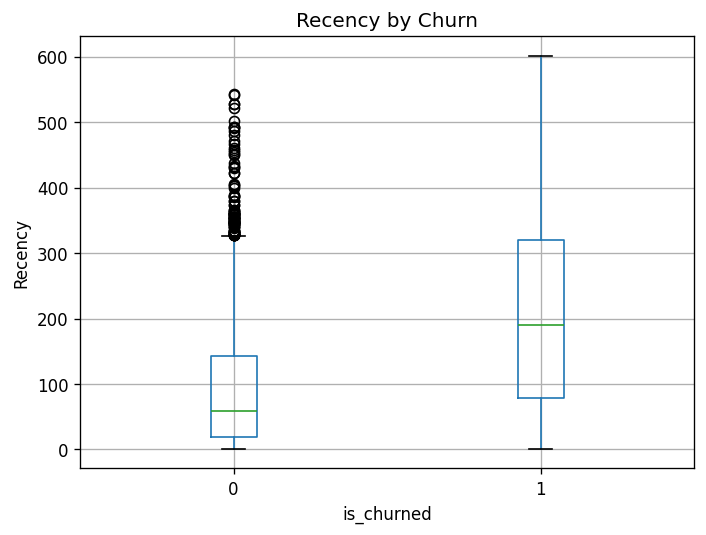

In [10]:
if 'Recency' in df.columns:
    fig = plt.figure(figsize=(6.2, 4))
    df.boxplot(column='Recency', by=TARGET_COL)
    plt.title('Recency by Churn')
    plt.suptitle('')
    plt.xlabel(TARGET_COL)
    plt.ylabel('Recency')
    save_or_show(fig, '03_recency_by_churn.png')
else:
    print('Recency column not found — skipping plot.')


### Interview mini‑Q (Plot 3)

1. **Why does Recency often dominate churn models?**  
2. **What’s the data leakage risk with Recency?** (label definition overlap)  
3. **How would you validate that Recency is not “cheating”?**


## 7️⃣ Plot 4 — Correlation matrix (Interview focus: multicollinearity)

Correlation helps you detect:
- redundant features (high correlation)
- features strongly associated with churn label
- potential multicollinearity for linear models


In [11]:
num_cols = df.select_dtypes(include='number').columns.tolist()
if TARGET_COL in num_cols:
    num_cols = [c for c in num_cols if c != TARGET_COL] + [TARGET_COL]

corr = df[num_cols].corr()

fig = plt.figure(figsize=(10, 6))
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title('Correlation Matrix (Numeric Features + Target)')
plt.tight_layout()
save_or_show(fig, '04_correlation_matrix.png')


💾 Saved: outputs\04_correlation_matrix.png


### Interview mini‑Q (Plot 4)

1. **If two features are correlated 0.95, what do you do?** (drop one, regularize, PCA)  
2. **Why do tree models care less about collinearity than logistic regression?**  
3. **Correlation ≠ causation — how do you explain that?**


## 8️⃣ Plot 5 — Country churn rate (Interview focus: segmentation)

This plot surfaces churn hotspots by geography (or any categorical segment).


In [12]:
if 'Country' in df.columns:
    churn_by_country = (
        df.groupby('Country')[TARGET_COL]
        .mean()
        .sort_values(ascending=False)
        .head(10)
    )

    fig = plt.figure(figsize=(7.2, 4))
    plt.barh(churn_by_country.index[::-1], churn_by_country.values[::-1])
    plt.title('Top Countries by Churn Rate (Top 10)')
    plt.xlabel('Churn rate')
    save_or_show(fig, '05_top_countries_churn.png')
else:
    print('Country label not available — skipping plot.')


💾 Saved: outputs\05_top_countries_churn.png


### Interview mini‑Q (Plot 5)

1. **What bias might exist in country churn comparisons?** (sample size, acquisition channels)  
2. **How would you add confidence intervals or minimum sample thresholds?**  
3. **What action could a business take from this plot?**


## 9️⃣ Optional: Simple segmentation (RFM buckets) — interview friendly

Even without a model, you can build segments to talk about customers.

Example:
- High Frequency + High Monetary → “VIPs”
- High Recency + Low Frequency → “At risk”


In [13]:
# Make a lightweight segmentation only if columns exist
needed = {'Recency', 'Frequency', 'Monetary'}
if needed.issubset(df.columns):
    seg = df.copy()

    # Quantile buckets (4 groups each)
    seg['R_bucket'] = pd.qcut(seg['Recency'], 4, labels=['R1_low', 'R2', 'R3', 'R4_high'])
    seg['F_bucket'] = pd.qcut(seg['Frequency'].rank(method='first'), 4, labels=['F1_low', 'F2', 'F3', 'F4_high'])
    seg['M_bucket'] = pd.qcut(seg['Monetary'], 4, labels=['M1_low', 'M2', 'M3', 'M4_high'])

    # Simple segment rule example
    seg['Segment'] = np.where(
        (seg['F_bucket'] == 'F4_high') & (seg['M_bucket'] == 'M4_high'),
        'VIP',
        np.where((seg['R_bucket'] == 'R4_high'), 'At_Risk', 'Standard')
    )

    segment_view = seg.groupby('Segment')[TARGET_COL].agg(['count', 'mean']).rename(columns={'mean':'churn_rate'})
    segment_view.sort_values('churn_rate', ascending=False)
else:
    print('RFM columns not found — skipping segmentation.')


### Interview mini‑Q (Segmentation)

1. **Why use segmentation before modeling?**  
2. **What’s the difference between business segments vs model clusters?**  
3. **How would you validate segments are stable over time?**


# ✅ Final Interview Preparation (End‑to‑End)

Use these to practice explaining your notebook like a story.

## A) Data & Pipeline
1. Why is this a **feature table** and not a transaction table?
2. What validation checks do you always do after reading a CSV?
3. How do you prevent schema mismatch bugs across environments?

## B) Business Understanding
4. What is churn in your project? How is it labeled?
5. What KPI would you present first to stakeholders and why?
6. What action would the business take from your dashboard?

## C) Modeling Readiness
7. If churn is imbalanced, which metrics matter most?
8. What leakage risks exist in churn datasets?
9. Which top 3 features do you expect to matter and why?

## D) Plot Interpretation
10. What does the churn distribution tell you?
11. What does higher Recency among churners imply?
12. If Monetary is higher for churners, what hypotheses do you propose?

## E) Production Thinking
13. How would you productionize this dashboard? (ETL schedule, data freshness, BI tool)
14. What monitoring would you add? (churn rate drift, feature drift)
15. How do you handle missing/incorrect country values safely?
